# You Only Look Once: Unified, Real-Time Object Detection
```
@article{DBLP:journals/corr/RedmonDGF15,
  author    = {Joseph Redmon and
               Santosh Kumar Divvala and
               Ross B. Girshick and
               Ali Farhadi},
  title     = {You Only Look Once: Unified, Real-Time Object Detection},
  journal   = {CoRR},
  volume    = {abs/1506.02640},
  year      = {2015},
  url       = {http://arxiv.org/abs/1506.02640},
  archivePrefix = {arXiv},
  eprint    = {1506.02640},
  timestamp = {Mon, 13 Aug 2018 16:48:08 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/RedmonDGF15.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
```

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

print('TensorFlow:', tf.__version__)

TensorFlow: 2.2.0-rc2


In [3]:
H, W = 448, 448
num_classes = 2
strategy = tf.distribute.MirroredStrategy()
batch_size = 4 * strategy.num_replicas_in_sync

print('\nNumber of Accelerators :', strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Number of Accelerators : 4


## Utility Functions

### Coverting between box formats
 - Boxes are represented in two formats
     - x1y1x2y2 : In this format the top left and bottom right
         coordinates are stored in the array
     - xywh : In this format the center of the box along with its 
         width and height are stored in the array
 - As you will see in the following cells, we will encounter both the formats, we will be using <br> the following function to convert between the formats.

In [4]:
def convert_boxes_xywh(boxes):
    x = (1 + boxes[..., 0] + boxes[..., 2]) / 2.0
    y = (1 + boxes[..., 1] + boxes[..., 3]) / 2.0
    w = 1 + boxes[..., 2] - boxes[..., 0]
    h = 1 + boxes[..., 3] - boxes[..., 1]
    return tf.stack([x, y, w, h], axis=-1)


def convert_boxes_x1y1x2y2(boxes):
    x1 = boxes[..., 0] - boxes[..., 2] / 2.0
    y1 = boxes[..., 1] - boxes[..., 3] / 2.0
    x2 = (boxes[..., 0] + boxes[..., 2] / 2.0) - 1
    y2 = (boxes[..., 1] + boxes[..., 3] / 2.0) - 1
    return tf.stack([x1, y1, x2, y2], axis=-1)

### Display Predictions
 - Simple functions to draw boxes along with their class names for vizualization

In [5]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)


def draw_boxes_cv2(image, boxes, categories):
    image = np.array(image, dtype=np.uint8)
    boxes = np.array(boxes, dtype=np.int32)
    categories = np.array(categories)
    for _box, _cls in zip(boxes, categories):
        text = _cls
        char_len = len(text) * 9
        text_orig = (_box[0] + 5, _box[1] - 6)
        text_bg_xy1 = (_box[0], _box[1] - 20)
        text_bg_xy2 = (_box[0] + char_len, _box[1])
        image = cv2.rectangle(image, text_bg_xy1, text_bg_xy2, [255, 252, 150],
                              -1)
        image = cv2.putText(image,
                            text,
                            text_orig,
                            cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            .6, [0, 0, 0],
                            5,
                            lineType=cv2.LINE_AA)
        image = cv2.putText(image,
                            text,
                            text_orig,
                            cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            .6, [255, 255, 255],
                            1,
                            lineType=cv2.LINE_AA)
        image = cv2.rectangle(image, (_box[0], _box[1]), (_box[2], _box[3]),
                              [30, 15, 30], 2)
    return image

# Data Pipeline
 - In this tutorial we will be training on the shapes dataset which can be generated <br> using the [generating_shapes_dataset](https://github.com/srihari-humbarwadi/tf_cv_tutorials/blob/master/notebooks/generating_shapes_dataset.ipynb) notebook
 - Each image has a size of [448, 448, 3]
 - Each image has one or more instances of `circle` and `rectangle`
 - Class encodings:
     - `circle` is encoded as `0`
     - `rectangle` is encoded as `1`

## Working with TFRecords

### Listing TFRecords
 - The training and validation tfrecords are stored with the prefix 'train' and 'val' respectively
 - Train tfrecords
     - train_0001.tfrecord
     - train_0002.tfrecord
     - . . .
 - Validation tfrecords
     - val_0001.tfrecord
     - val_0002.tfrecord
     - . . .

In [6]:
shapes_dataset_tfrecords_path = '../tutorials/data/shapes_dataset_tfrecords'
train_tfrecords_pattern = shapes_dataset_tfrecords_path + '/train*'
val_tfrecords_pattern = shapes_dataset_tfrecords_path + '/val*'

train_tfrecords = tf.data.Dataset.list_files(train_tfrecords_pattern)
val_tfrecords = tf.data.Dataset.list_files(val_tfrecords_pattern)

### Reading from TFRecords
 - The shapes dataset has already been converted into tfrecords for efficient data loading. This has <br> been done using the [creating_tfrecords](https://github.com/srihari-humbarwadi/tf_cv_tutorials/blob/master/notebooks/creating_tfrecords.ipynb) notebook
 - At the core of each tfrecord sample is the `tf.train.Example` which is written into tfrecords after <br> being serialized as a string. The samples have a very specific structure, and it is necessary that we know <br> this exact structure in order to decode and parse the tfrecords.
 - Each sample is parsed using the `tf.io.parse_single_example` which takes in two args
     - `serialized`: Serialized `tf.train.Example` proto
     - `features`: A dict with input feature names as keys and its feature type as value
     
#### Input feature dict
```
{
    'image': tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'classes': tf.io.VarLenFeature(tf.int64),
}
```
 - There are two types of features that we are interested to store
     - `tf.io.FixedLenFeature`: Used to store fixed length features ie. when number of elements is known. <br> We store raw image byte strings using this type of feature, since we have a single image per sample.<br> On parsing, it returns a dense tensor.
     - `tf.io.VarLenFeature`: Used to store variable length features such as bounding box coordinates and <br> their classes, we use this to store the same. On parsing, it return a sparse tensor. And since majority of the <br> operations that we will be doing are with dense tensors we need to convert it back to a dense tensor.<br> This is straight forward with the `tf.sparse.to_dense` function.

We can now write our own function `parse_example` to parse `tf.train.Example` serialized strings to <br> give us `(image, boxes, classes)`. With the following shapes, assuming there are N objects in the current sample.
 - `image`: [448, 448, 3]
 - `boxes`: [N, 4]
 - `classes`: [N]

In [7]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'xmins': tf.io.VarLenFeature(tf.float32),
        'ymins': tf.io.VarLenFeature(tf.float32),
        'xmaxs': tf.io.VarLenFeature(tf.float32),
        'ymaxs': tf.io.VarLenFeature(tf.float32),
        'classes': tf.io.VarLenFeature(tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example_proto,
                                                feature_description)
    image = tf.io.decode_image(parsed_example['image'], channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image.set_shape([None, None, 3])
    boxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs']),
    ],
                     axis=-1)
    classes = tf.sparse.to_dense(parsed_example['classes'])
    return image, boxes, classes

# Understanding how YOLO works
YOLO - You Only Look Once is one of those object detection models that focuses on high inference speeds, and to achieve this it has a couple of tricks up its sleeves. It is capable of localizing and classifying the objects in a given image by making use of a single network, which means that there is no need for multiple subnetworks for generating proposals and then classifying them. At the time when the YOLO paper was published, it was one of the fastest object detection models which had a good mAP score on the PASCAL VOC dataset.

The YOLO model consists of a convolutional feature extractor, and a cleverly designed loss function that does most of the heavy lifting. The output of the feature extractor has a stride of 64, which means that the output feature map will have the input image downsampled by a factor of 64. For the rest of the tutorial, we will be assuming that this feature map has a height and width of S. Thus for a batch size of N the feature map would have a shape `[N, S, S, F]`, where F is the number of convolutional filters in the last convolutional layer. The fully connected layers that follow the feature extractor help to predict the coordinates and the class scores for each location on the grid. The output of the network is an SxS grid, with each grid location, having `B` box predictions and `C` class scores. The target vector for each grid location has  B * 5 + C values, with each of the boxes encoded as 5 values. Along with the 4 coordinate values `x, y, w, h`, the boxes also have a confidence score. These `B` boxes will be referred hereafter as **predictor boxes**. The final prediction tensor has the shape `[N, S, S, B * 5 + C]`, all the target tensor values lie in interval `[0, 1)`.

Note: The value of `S` be calculated by `INPUT_DIM // STRIDE` 

### Values for constants used in this tutorial
 - B or **predictor boxes** per grid location : **2**
 - stride of the network: **64.0**
 - Classes: **2**
 - Model input shape: **[448, 448, 3]**
 - Shape of the grid: **[7, 7]** *(without batch axis)*
 - Shape of the target: **[7, 7, 2 * 5 + 2]** => **[7, 7, 12]** *(without batch axis)*

## Encoding targets
Let us understand the target tensor encoding with an example. Suppose we have an image that has 4 objects, each belonging to either `circle` or `rectangle` class. Each object has a bounding box represented by 4 coordinates `x, y, w, h`, `x` and `y` are the coordinates for the center and `w` and `h` represent the width and height respectively. In the example below, there are 2 instances of `circle` class and 2 instances of `rectangle` class. Out of the `SxS` grid cells, the cell in which the center of the objects falls, is responsible for the object's detection.

The `w` and `h` values are divided with the width and height of the image respectively so that we get coordinates relative to the image size this ensures that they lie in the interval `[0, 1)`. And the `x` and `y` values are normalized using the coordinates of the grid cell which is responsible for the detection. The confidence scores for all the **predictor boxes** is set to 1, since we want this value to denote the presence of an object. The classes follow one hot encoding.

#### Encoding example
<img src="https://raw.githubusercontent.com/srihari-humbarwadi/tf_cv_tutorials/master/assets/images/yolo_grid_viz.png" />
Follow the steps given below to encode the example image.

##### Steps
To make sure our code runs fast, we vectorize all our operations and thus avoiding the need for loops. 
 - Convert the box coordinates from `x1y1x2y2` to `xywh` using the `convert_boxes_xywh` function we implemented earlier.
    ```
    boxes_xywh = <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
                     array([[ 97., 338., 137., 137.],
                            [209., 205.,  99.,  47.],
                            [369., 289., 125., 125.],
                            [307., 175.,  60., 104.]], dtype=float32)>
    ```
    
 - Use the `tf.one_hot` function to one hot encode the classes. Here we set `depth` to 2 since our shapes dataset has 2 classes.
    ```
    classes = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                  array([[1., 0.],
                         [0., 1.],
                         [1., 0.],
                         [0., 1.]], dtype=float32)>
    ```
    
 - Use `tf.ones` to make a tensor filled with ones with shape `[num_objects, 1]`, in this example `num_objects == 4`, this will be as the confidence scores for each **predictor box**
 - Now to find the grid cells responsible for the detections, we perform integer division of the centers of the boxes and the output stride of the network, in this case the stride is equal to 64.0, `tf.math.floordiv` lets us perform integer division.
    ```
    box_centers = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                     array([[ 97., 338.],
                            [209., 205.],
                            [369., 289.],
                            [307., 175.]], dtype=float32)>
     
    grid_offset = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                     array([[1., 5.],
                            [3., 3.],
                            [5., 4.],
                            [4., 2.]], dtype=float32)>
               
    ```
    Here are the (x, y) coordinates of the grid cells 
     - Object #1 (green circle)  : [1, 5] 
     - Object #2 (red rectangle)   : [3, 3] 
     - Object #3 (red circle)      : [5, 4] 
     - Object #4 (green rectangle) : [4, 2]
    
    
 - We still need to normalize the (x, y) coordinates of the box centers, using the coordinates of the grid cells that we calculated in the previous step, in other words we need to find $\frac{\Delta x}{stride}$ and $\frac{\Delta y}{stride}$ shown in the figure, this can be rewritten using the location of the grid cell on the input image give by - 
 
<img src="https://raw.githubusercontent.com/srihari-humbarwadi/tf_cv_tutorials/master/assets/images/yolo_box_normalization.png" style="width: 55%;"/>

 
 - After doing the above operation we have, 
```
    normalized_box_centers = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                                array([[0.515625, 0.28125 ],
                                       [0.265625, 0.203125],
                                       [0.765625, 0.515625],
                                       [0.796875, 0.734375]], dtype=float32)>
```

- Now divide the box widths and heights by the input shape to normalize the values, in this case `[448, 448]`
    ```
    box_wh = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                array([[137., 137.],
                       [ 99.,  47.],
                       [125., 125.],
                       [ 60., 104.]], dtype=float32)>

    normalized_wh = <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
                        array([[0.30580357, 0.30580357],
                               [0.22098215, 0.10491072],
                               [0.27901787, 0.27901787],
                               [0.13392857, 0.23214285]], dtype=float32)>

    ```


- Now putting all this together we have, 

```
    normalized_box = tf.concat([normalized_box_centers, normalized_wh], axis=-1)

    normalized_box = <tf.Tensor: shape=(4, 4), dtype=float32, numpy
                     array([[0.515625  , 0.28125   , 0.30580357, 0.30580357],
                            [0.265625  , 0.203125  , 0.22098215, 0.10491072],
                            [0.765625  , 0.515625  , 0.27901787, 0.27901787],
                            [0.796875  , 0.734375  , 0.13392857, 0.23214285]], dtype=float32)>
```

 - Initialize a label tensor with zeros with the shape `[S, S, 2 * 5 + C]` ie. [7, 7, 12]. 
 
 - Create the targets for each of the object, the targets now look as shown in figure below.
```
     targets = tf.concat([pc, pc, normalized_box, normalized_box, classes],
                        axis=-1)
```
<img src="https://raw.githubusercontent.com/srihari-humbarwadi/tf_cv_tutorials/master/assets/images/yolo_targets.png"/>


 - The last step is assigning the targets to the grid cells reponsible to detect the object, In other words we want the targets of
     - Object #1 (green circle) to be assigned to the grid cell    : [1, 5] 
     - Object #2 (red rectangle) to be assigned to the grid cell   : [3, 3] 
     - Object #3 (red circle) to be assigned to the grid cell      : [5, 4] 
     - Object #4 (green rectangle) to be assigned to the grid cell : [4, 2]
     
 This can be done with  `tf.tensor_scatter_nd_update` function. Which takes 3 arguments, `tensor`, `indices`, `updates`. This function applies sparse updates to the tensor at the locations provided by the indices. Here in our case, we assign the targets for each object to the label tensor using `grid_offset` as indices.
     
```
    targets = tf.reshape(targets, shape=[1, num_objects, 2 * 5 + num_classes])

    # x, y -> y, x; because axis 0 of the tensor is the y axis of the 2d coordinate system
    grid_offset_reversed = tf.reverse(grid_offset, axis=[1])
    indices = tf.cast(grid_offset_reversed, dtype=tf.int32)
    indices = tf.reshape(indices, shape=[1, num_objects, 2])

    label = tf.tensor_scatter_nd_update(label, indices, targets)
```

Putting all of this together we have the `create_label` function, which will be used in the `tf.data` pipeline.

In [8]:
def create_label(boxes,
                 classes,
                 input_size=[448, 448],
                 grid_shape=[7, 7],
                 stride=64,
                 num_classes=2):
    boxes = tf.cast(boxes, dtype=tf.float32)
    boxes_xywh = convert_boxes_xywh(boxes)

    classes = tf.one_hot(classes, depth=num_classes, dtype=tf.float32)

    num_objects = tf.shape(classes)[0]
    pc = tf.ones(shape=[num_objects, 1], dtype=tf.float32)
    box_centers = boxes_xywh[:, :2]
    box_wh = boxes_xywh[:, 2:]

    grid_offset = tf.math.floordiv(box_centers, stride)
    normalized_box_centers = box_centers / stride - grid_offset
    normalized_wh = box_wh / tf.constant(input_size, dtype=tf.float32)

    label_shape = [grid_shape[0], grid_shape[1], 2 * 5 + num_classes]
    label = tf.zeros(shape=label_shape, dtype=tf.float32)

    normalized_box = tf.concat([normalized_box_centers, normalized_wh], axis=-1)

    targets = tf.concat([pc, pc, normalized_box, normalized_box, classes],
                        axis=-1)
    targets = tf.reshape(targets, shape=[1, num_objects, 2 * 5 + num_classes])

    # x, y -> y, x;  because axis 0 of the tensor is the y axis of the 2d coordinate system
    grid_offset_reversed = tf.reverse(grid_offset, axis=[1])
    indices = tf.cast(grid_offset_reversed, dtype=tf.int32)
    indices = tf.reshape(indices, shape=[1, num_objects, 2])

    label = tf.tensor_scatter_nd_update(label, indices, targets)
    return label

### Building tf.data pipeline
 - To summarize the functions we implemented above, we have
     - `parse_example` fuction takes in a single example proto and gives us 3 tensors,  `image`, `boxes`, `classes`
     - `create_label` function takes in boxes and classes, and constructs a label tensor for the sample
     
 - We need to implement two more functions,
     - `random_flip_data`: This function takes in a image and the boxes it has, and flips them horizontally. To introduce randomness we flip with a probablity of 50%. This can be done by sampling a number from uniform distribution and checking if it is greater or leser than `0.5`. Doing this is straightforward with `tf.random.uniform(()) > 0.5`. Images can be flipped horizontally with the `tf.image.flip_left_right` function. And to flip boxes, we need to `x1` and `x2` coordinates by doing $w - x1$ and $w - x2$ where $w$ is the width of the image, and since by definition $x1 < x2$, it is clear that $w - x1 > w - x2$ and hence $x1_{new} = w - x2$ and $x2_{new} = w - x1$, so our flipped box would be `[w - x2, y1, w - x1, y2]`
     
 Note: All these functions work with a single sample at a time, so there is not batch axis present in the tensors. This is by design, because as you will see `tf.data.Dataset` API helps us to create batches easily.
 
# Todo
 - We need

In [9]:
def random_flip_data(image, boxes):
    w = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [w - boxes[:, 2], boxes[:, 1], w - boxes[:, 0], boxes[:, 3]],
            axis=-1)
    return image, boxes


def parse_and_create_label(example_proto):
    image, boxes, classes = parse_example(example_proto)
    image = (image - 127.5) / 127.5
    image, boxes = random_flip_data(image, boxes)
    label = create_label(boxes, classes)
    return image, label


def build_dataset(tfrecords, batch_size):
    dataset = tfrecords.interleave(
        tf.data.TFRecordDataset,
        cycle_length=8,
        block_length=32,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(512)
    dataset = dataset.map(parse_and_create_label,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Building the YOLO Model

In [10]:
def conv_block(tensor, filters, kernel_size, stride):
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               strides=stride,
                               padding='same',
                               use_bias=False,
                               kernel_initializer='he_normal')(tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    return x


def build_model(H, W, num_classes):
    stride = 64
    grid_shape = [H // stride, W // stride]

    image_input = tf.keras.Input(shape=[H, W, 3], name='image_input')
    x = conv_block(image_input, filters=16, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=32, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=64, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=128, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=256, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=512, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    predictions = tf.keras.layers.Conv2D(filters=(2 * 5 + num_classes),
                                         kernel_size=1)(x)
    return tf.keras.Model(inputs=[image_input],
                          outputs=[predictions],
                          name='yolo')

## Decoding Predictions

In [11]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(self,
                 input_size=[448, 448],
                 stride=64.0,
                 iou_threshold=0.5,
                 score_threshold=0.6,
                 **kwargs):
        super(DecodePredictions, self).__init__(**kwargs)
        self.input_size = tf.constant(input_size, dtype=tf.float32)
        self.stride = tf.constant(stride, dtype=tf.float32)
        self.grid_shape = self.input_size / self.stride
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        self._build_meshgrid()

    def _build_meshgrid(self):
        self.meshgrid = tf.stack(tf.meshgrid(tf.range(self.grid_shape[0]),
                                             tf.range(self.grid_shape[1])),
                                 axis=-1)
        self.meshgrid = tf.reshape(
            self.meshgrid,
            shape=[1, self.grid_shape[0], self.grid_shape[1], 1, 2])
        self.meshgrid = tf.tile(self.meshgrid, multiples=[1, 1, 1, 2, 1])

    def call(self, inputs, square_wh, extract_boxes):
        cls_pred = inputs[:, :, :, 10:]
        object_scores = inputs[:, :, :, :2]

        box_coords = tf.reshape(
            inputs[:, :, :, 2:10],
            shape=[-1, self.grid_shape[0], self.grid_shape[1], 2, 4])
        box_centers = box_coords[:, :, :, :, :2]
        box_wh = box_coords[:, :, :, :, 2:]

        denormalized_centers = (box_centers + self.meshgrid) * self.stride
        if square_wh:
            box_wh = tf.square(box_wh)
        denormalized_wh = box_wh * tf.reshape(self.input_size,
                                              shape=[1, 1, 1, 1, 2])
        denormalized_boxes = tf.concat([denormalized_centers, denormalized_wh],
                                       axis=-1)

        if not extract_boxes:
            return denormalized_boxes
        denormalized_boxes = tf.reshape(denormalized_boxes, [-1, 4])

        cls_ids = tf.argmax(cls_pred, axis=-1)
        cls_ids = tf.tile(tf.expand_dims(cls_ids, axis=-1),
                          multiples=[1, 1, 1, 2])
        cls_ids = tf.reshape(cls_ids, [-1])
        cls_scores = tf.reduce_max(cls_pred, axis=-1)
        cls_scores = tf.tile(tf.expand_dims(cls_scores, axis=-1),
                             multiples=[1, 1, 1, 2])

        class_probs = cls_scores * object_scores
        class_probs = tf.reshape(class_probs, [-1])

        denormalized_boxes_x1y1x2y2 = convert_boxes_x1y1x2y2(denormalized_boxes)
        indices = tf.image.non_max_suppression(denormalized_boxes_x1y1x2y2,
                                               class_probs, 100,
                                               self.iou_threshold,
                                               self.score_threshold)

        nms_boxes = tf.gather(denormalized_boxes_x1y1x2y2,
                              indices,
                              name='boxes')
        nms_class_probs = tf.gather(class_probs, indices, name='scores')
        nms_cls_ids = tf.gather(cls_ids, indices, name='class_ids')
        return {
            'boxes': nms_boxes,
            'class_ids': nms_cls_ids,
            'scores': nms_class_probs
        }

    def compute_output_shape(self, input_shape):
        return ([None, 4], [None], [None])

## Implementing the YOLO loss function

In [12]:
class YoloLoss(tf.losses.Loss):

    def __init__(self,
                 input_size=[448, 448],
                 num_classes=10,
                 stride=64.0,
                 lambdacoord=5.0,
                 lambdanoobj=0.5):
        super(YoloLoss, self).__init__(reduction=tf.losses.Reduction.NONE,
                                       name='YoloLoss')
        self.lambdacoord = lambdacoord
        self.lambdanoobj = lambdanoobj
        self.decoder = DecodePredictions(input_size=input_size, stride=stride)

    def compute_iou(self, boxes1, boxes2):
        boxes1_t = convert_boxes_x1y1x2y2(boxes1)
        boxes2_t = convert_boxes_x1y1x2y2(boxes2)

        lu = tf.maximum(boxes1_t[:, :, :, :, :2], boxes2_t[:, :, :, :, :2])
        rd = tf.minimum(boxes1_t[:, :, :, :, 2:], boxes2_t[:, :, :, :, 2:])

        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[:, :, :, :, 0] * intersection[:, :, :, :, 1]

        square1 = boxes1[:, :, :, :, 2] * boxes1[:, :, :, :, 3]
        square2 = boxes2[:, :, :, :, 2] * boxes2[:, :, :, :, 3]

        union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
        return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

    @tf.function
    def call(self, y_true, y_pred):
        y_pred_shape = tf.shape(y_pred)

        cls_true = y_true[:, :, :, 10:]
        cls_pred = y_pred[:, :, :, 10:]

        pc_true = y_true[:, :, :, :1]
        pc_pred = y_pred[:, :, :, :2]

        box_coord_true = y_true[:, :, :, 2:10]
        box_coord_true = tf.reshape(
            box_coord_true,
            shape=[y_pred_shape[0], y_pred_shape[1], y_pred_shape[2], 2, 4])

        box_coord_pred = y_pred[:, :, :, 2:10]
        box_coord_pred = tf.reshape(
            box_coord_pred,
            shape=[y_pred_shape[0], y_pred_shape[1], y_pred_shape[2], 2, 4])

        box_true_xy = box_coord_true[:, :, :, :, :2]
        box_pred_xy = box_coord_pred[:, :, :, :, :2]

        box_true_wh_sqrt = tf.sqrt(box_coord_true[:, :, :, :, 2:])
        box_pred_wh_sqrt = box_coord_pred[:, :, :, :, 2:]

        box_coord_true_denormalized = self.decoder(y_true,
                                                   square_wh=False,
                                                   extract_boxes=False)
        box_coord_pred_denormalized = self.decoder(y_pred,
                                                   square_wh=True,
                                                   extract_boxes=False)

        ious = self.compute_iou(box_coord_true_denormalized,
                                box_coord_pred_denormalized)
        ious_max = tf.reduce_max(ious, axis=-1, keepdims=True)

        object_mask = tf.cast(tf.equal(pc_true, 1.0), dtype=tf.float32)
        predictor_mask = tf.cast(tf.equal(ious, ious_max), dtype=tf.float32)
        predictor_mask = predictor_mask * tf.tile(object_mask,
                                                  multiples=[1, 1, 1, 2])
        predictor_mask_loc = tf.tile(tf.expand_dims(predictor_mask, axis=-1),
                                     multiples=[1, 1, 1, 1, 2])
        noobj_mask = tf.ones_like(predictor_mask,
                                  dtype=tf.float32) - predictor_mask

        localization_loss_xy = tf.reduce_sum(
            predictor_mask_loc * tf.square(box_true_xy - box_pred_xy),
            axis=[1, 2, 3, 4])
        localization_loss_wh = tf.reduce_sum(
            predictor_mask_loc * tf.square(box_true_wh_sqrt - box_pred_wh_sqrt),
            axis=[1, 2, 3, 4])
        localization_loss = localization_loss_xy + localization_loss_wh

        confidence_loss_obj = tf.reduce_sum(predictor_mask *
                                            tf.square(ious - pc_pred),
                                            axis=[1, 2, 3])
        confidence_loss_noobj = tf.reduce_sum(noobj_mask * tf.square(pc_pred),
                                              axis=[1, 2, 3])

        classification_loss = tf.reduce_sum(object_mask *
                                            tf.square(cls_true - cls_pred),
                                            axis=[1, 2, 3])

        loss = (self.lambdacoord * localization_loss) + confidence_loss_obj + (
            self.lambdanoobj * confidence_loss_noobj) + classification_loss
        return loss

## Initializing and training the model

In [13]:
with strategy.scope():
    model = build_model(H, W, 2)
    train_dataset = build_dataset(train_tfrecords, batch_size)
    val_dataset = build_dataset(val_tfrecords, batch_size)
    loss_fn = YoloLoss([H, W], 2, 64.0)

    callbacks = [
        tf.keras.callbacks.TensorBoard(
            log_dir='../model_files/yolo_v1/tensorboard'),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=
            '../model_files/yolo_v1/checkpoints/yolo_v1_weights_{val_loss:.2f}',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)
    ]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [17]:
lr = 0.00004 * strategy.num_replicas_in_sync
model.compile(optimizer=tf.optimizers.Adam(lr), loss=loss_fn)
model.fit(train_dataset,
          validation_data=train_dataset,
          epochs=25,
          steps_per_epoch=10000 // batch_size,
          validation_steps=2500 // batch_size,
          callbacks=callbacks)

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1
624/625 [============================>.] - ETA: 0s - loss: 7.6490
Epoch 00001: val_loss improved from inf to 1.21077, saving model to ../model_files/yolo_v1/checkpoints/yolo_v1_weights_1.21
625/625 [==============================] - 30s 48ms/step - loss: 7.6390 - val_loss: 1.2108
Epoch 2/25
624/625 [============================>.] - ETA: 0s - loss: 1.0400
Epoch 00002: val_loss improved from 1.21077 to 0.94879, saving model to ../model_files/yolo_v1/checkpoints/yolo_v1_weights_0.95
625/625 [==============================] - 30s 48ms/step - loss: 1.0395 - val_loss: 0.9488
Epoch 3/25
624/625 [============================>.] - ETA: 0s - loss: 0.7572
Epoch 00003: val_loss improved from 0.94879 to 0.64369, saving model to ../model_files/yolo_v1/checkpoints/yolo_v1_weights_0.64
625/625 [==========================

### Loading best weights

In [18]:
best_weights = tf.train.latest_checkpoint('../model_files/yolo_v1/checkpoints')
model.load_weights(best_weights)
print('Loaded weights from :', best_weights)

Loaded weights from : ../model_files/yolo_v1/checkpoints/yolo_v1_weights_0.06


### Building the Inference Model

In [30]:
predictions = model.output
x = DecodePredictions(input_size=[448, 448],
                      stride=64.0,
                      iou_threshold=0.5,
                      score_threshold=0.4)(predictions,
                                           extract_boxes=True,
                                           square_wh=True)

inference_model = tf.keras.Model(inputs=model.input, outputs=x)

# Vizualizing Results

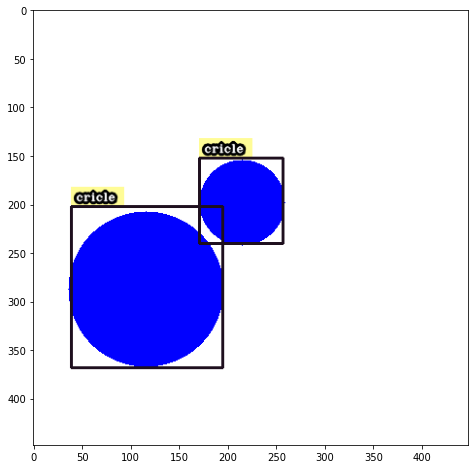

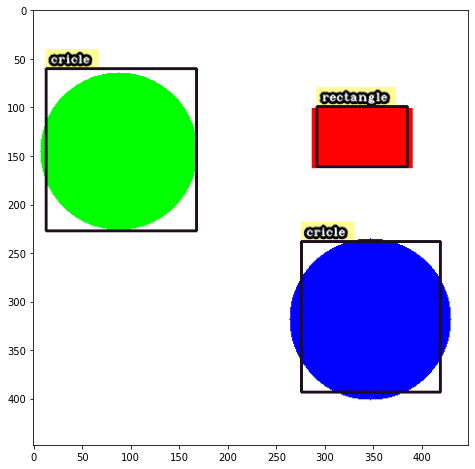

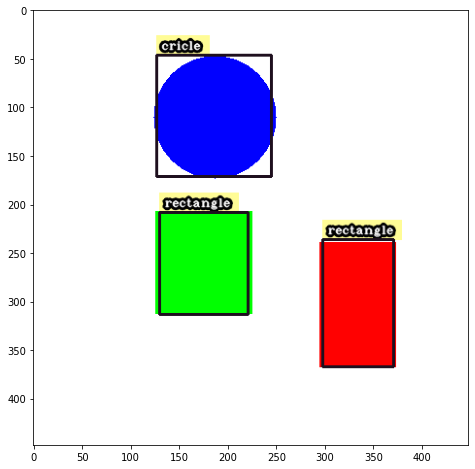

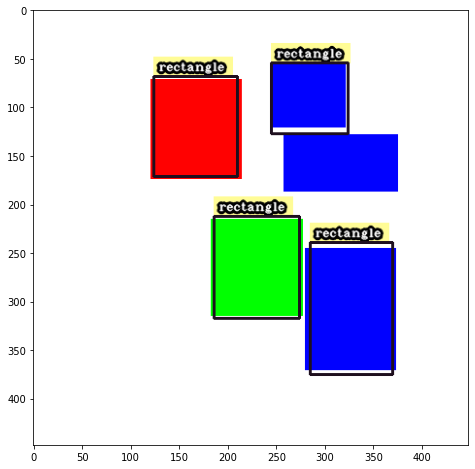

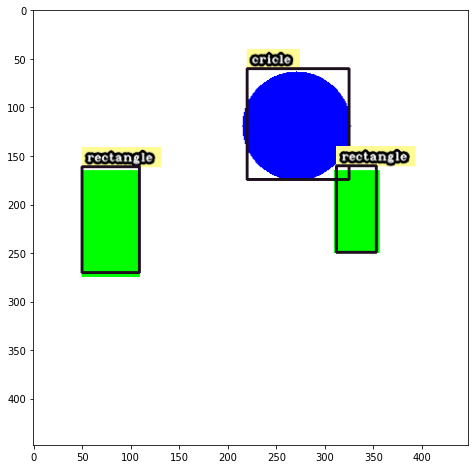

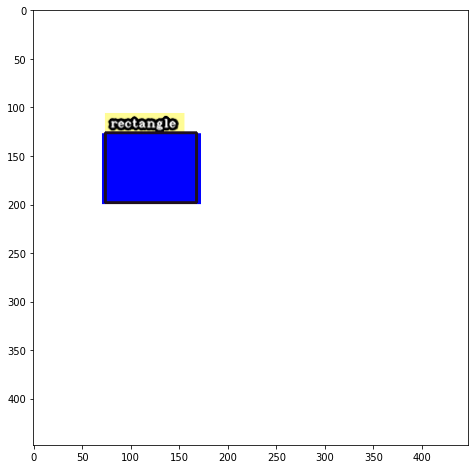

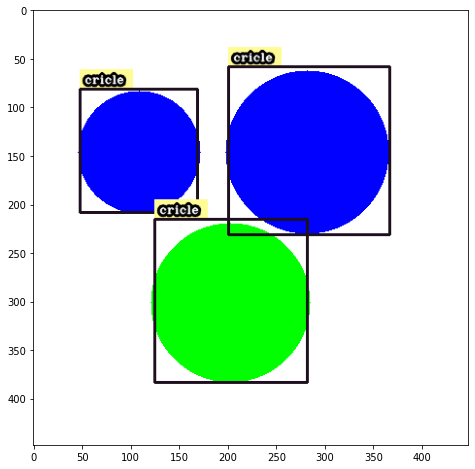

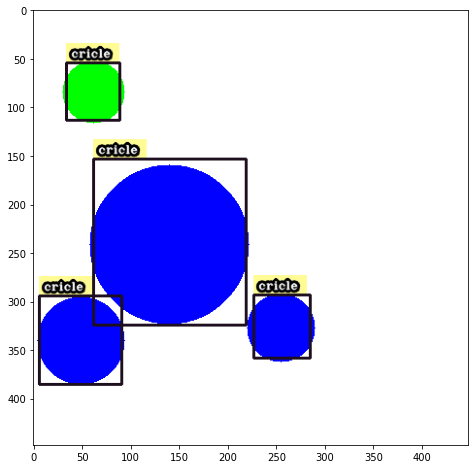

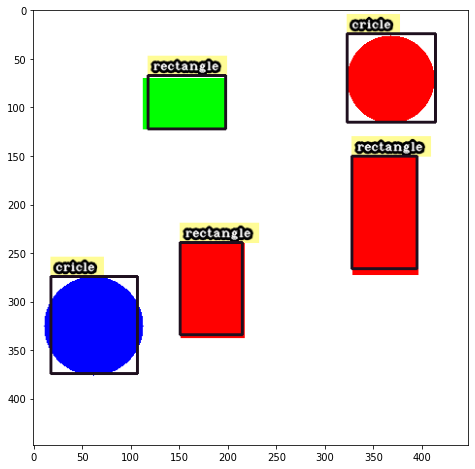

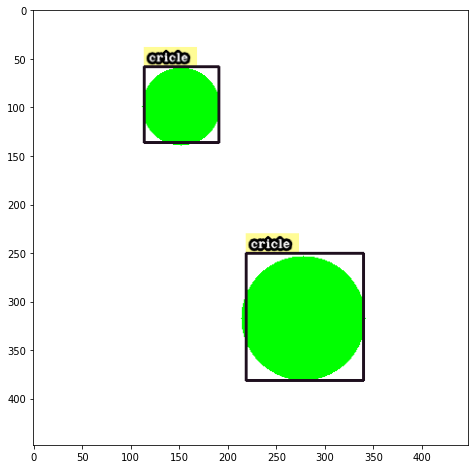

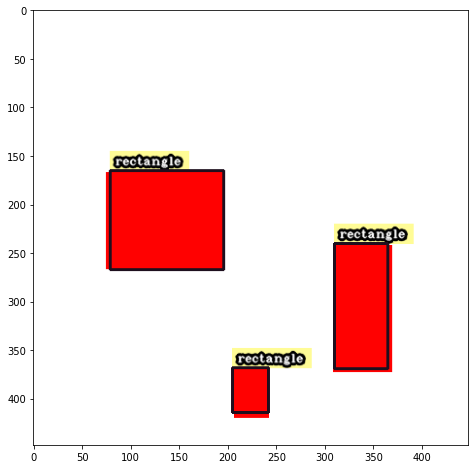

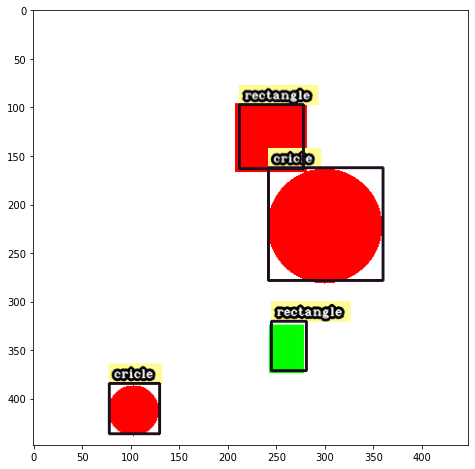

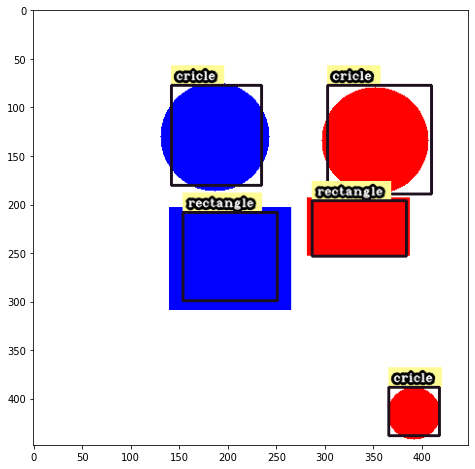

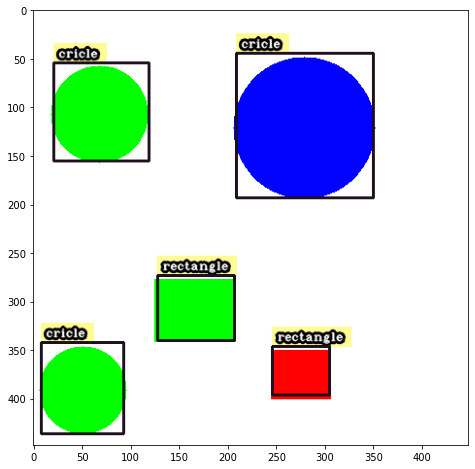

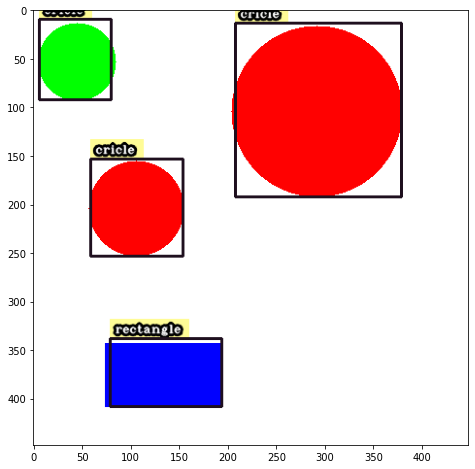

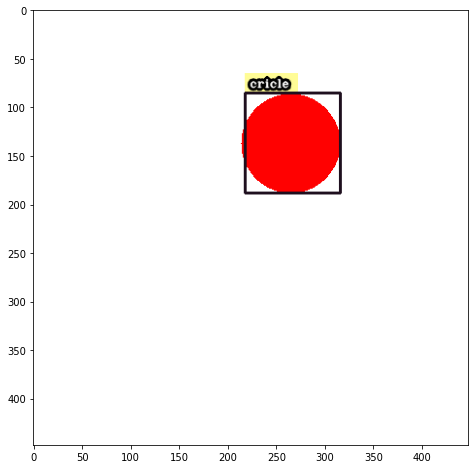

In [33]:
for images, _ in val_dataset:
    for i in range(images.shape[0]):
        image = images[i]
        prediction = inference_model(image[None, ...], training=False)
        boxes, classes, scores = prediction['boxes'], prediction[
            'class_ids'], prediction['scores']
        classes = [
            'cricle' if cls_id == 0 else 'rectangle' for cls_id in classes
        ]
        viz_image = draw_boxes_cv2(image * 255, boxes, classes)
        imshow(viz_image)
    break

### Exporting `saved_model`

In [ ]:
tf.saved_model.save(inference_model, export_dir='../model_files/yolo_v1/v1')

### Loading `saved_model`

In [35]:
loaded_model = tf.saved_model.load('../model_files/yolo_v1/v1')

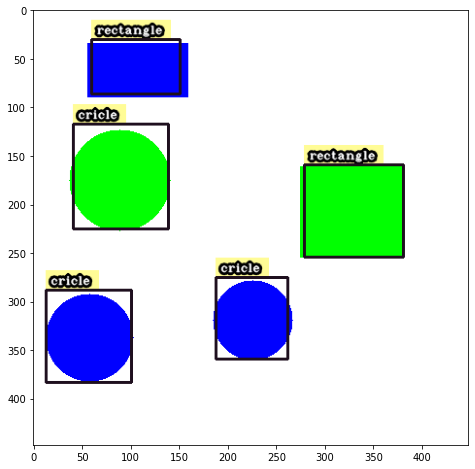

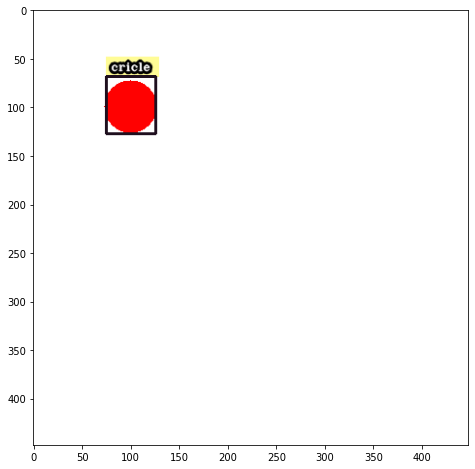

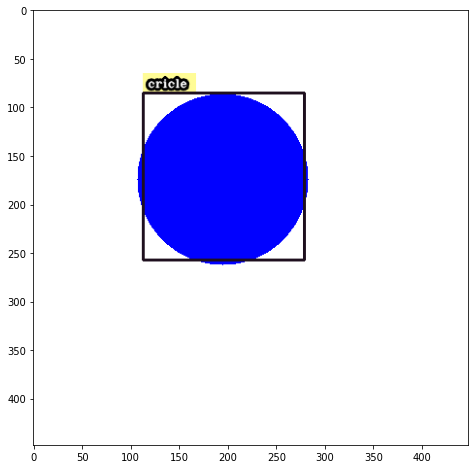

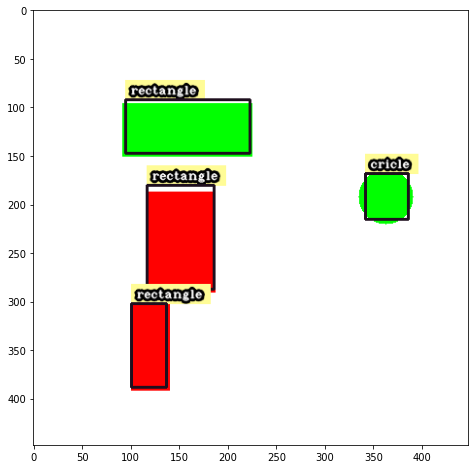

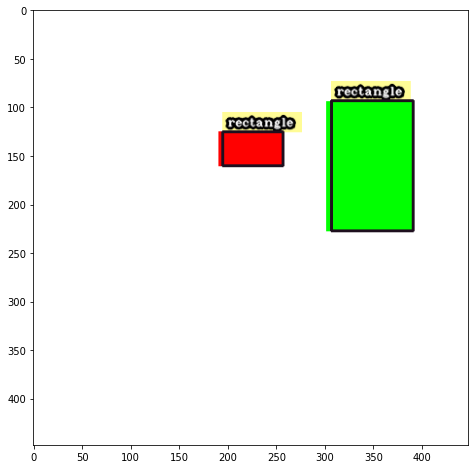

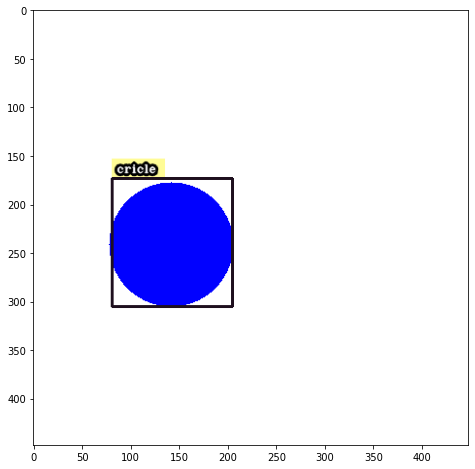

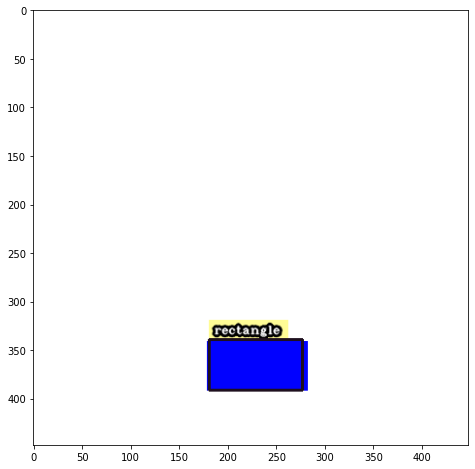

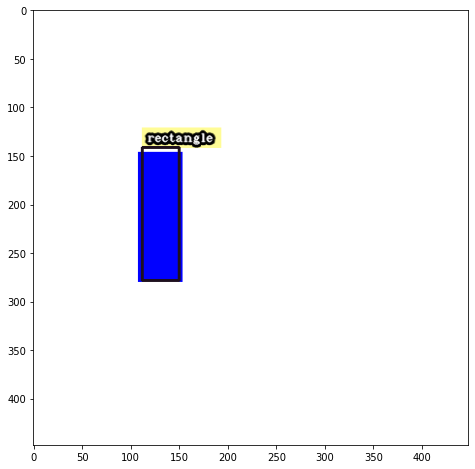

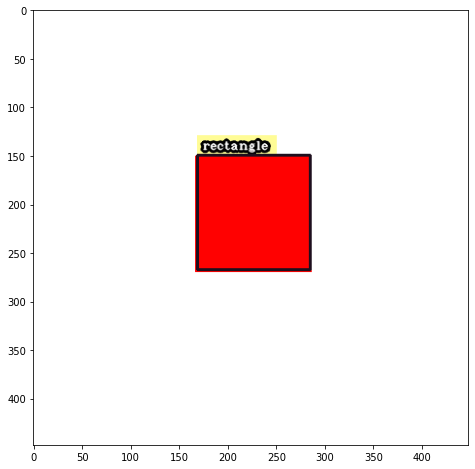

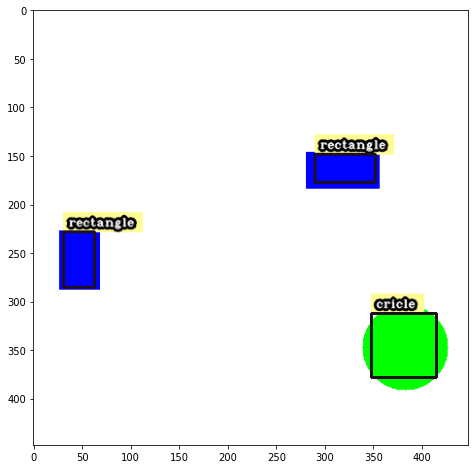

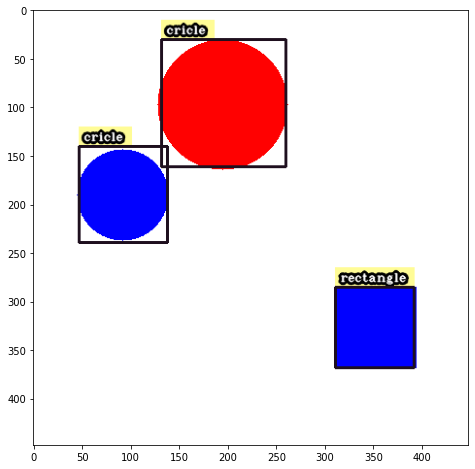

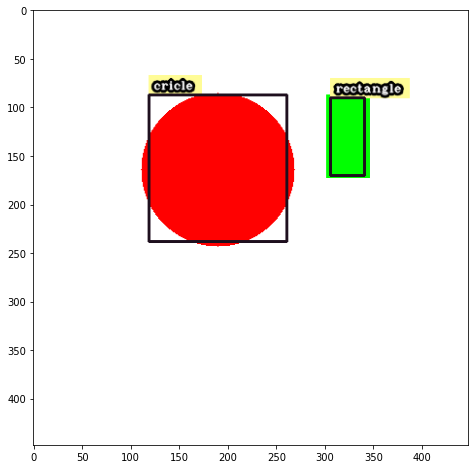

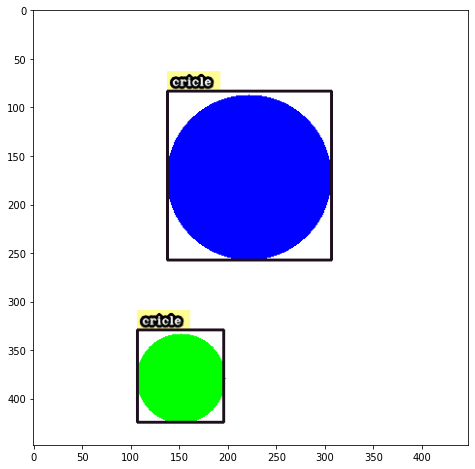

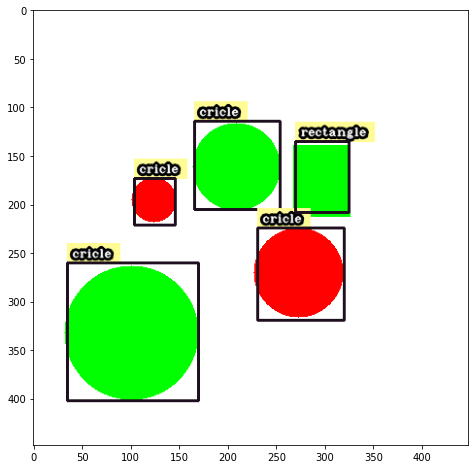

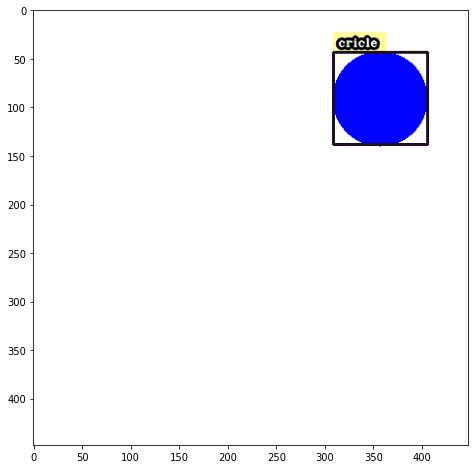

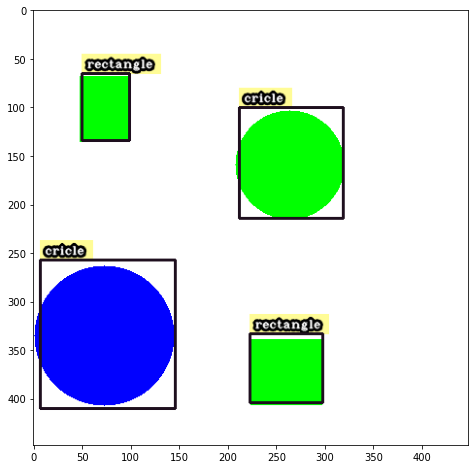

In [36]:
for images, _ in val_dataset:
    for i in range(images.shape[0]):
        image = images[i]
        prediction = inference_model(image[None, ...], training=False)
        boxes, classes, scores = prediction['boxes'], prediction[
            'class_ids'], prediction['scores']
        classes = [
            'cricle' if cls_id == 0 else 'rectangle' for cls_id in classes
        ]
        viz_image = draw_boxes_cv2(image * 255, boxes, classes)
        imshow(viz_image)
    break